# Gain demonstration notebook

### This notebook uses exclusively synthetic data.  All synthetic data are generated within the notebook.

### To run this notebook, you will need to first compile the Cython module.  

You can download the files setup.py and fitramp_cython.pyx, supplied with this notebook, and run

`python setup.py build_ext --inplace`

You will also need `fit_gain.py` and `fitramp.py`.

Estimated run time for the notebook: 2-10 minutes, mostly in the last cell.  Reduce the quantity `niterations` to reduce run time.

In [1]:
import numpy as np
import fit_gain
import fitramp
import fitramp_cython
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 16
rcParams['savefig.facecolor'] = 'white'
rcParams['axes.labelsize'] = 16
rcParams['xtick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True
rcParams['ytick.minor.visible'] = True
rcParams['lines.linewidth'] = 3

Set up some synthetic ramps.

In [2]:
truesig = 10  # in DN
Nramps = 100  # number of ramps
Nres = 30    # number of resultants/ramp
truegain = 1.0 # electrons/DN

# count rate in units of electrons per read
countrate = np.random.rand(Nramps)*100 + 50
# make the first 24 ramps dark (zero count rate).
countrate[:24] = 0
countratesidentical = False


# Are we assuming that all pixels have the same count rate?
# If so, the lines above should read something like
#countrate = 200
#countratesidentical = True

readtimes = np.arange(Nres) + 1

# Make some ramps with the desired count rates and the correct read
# and photon noise.  Convert read noise to electrons, make the ramps,
# and then convert back to DN.

ramps = fitramp.getramps(countrate, truesig*truegain, readtimes, nramps=Nramps)/truegain

# a scaling factor for the search regions; this makes the plots look nicer over a 
# wide range of numbers of ramps and resultants/ramp

s = np.sqrt(30000/(Nramps*Nres))

Compute a two-dimensional log likelihood, with linear spacing in gain and read noise.  

Compute contours to the log likelihood, both explicitly and by fitting a quadratic form.

(29, 100)


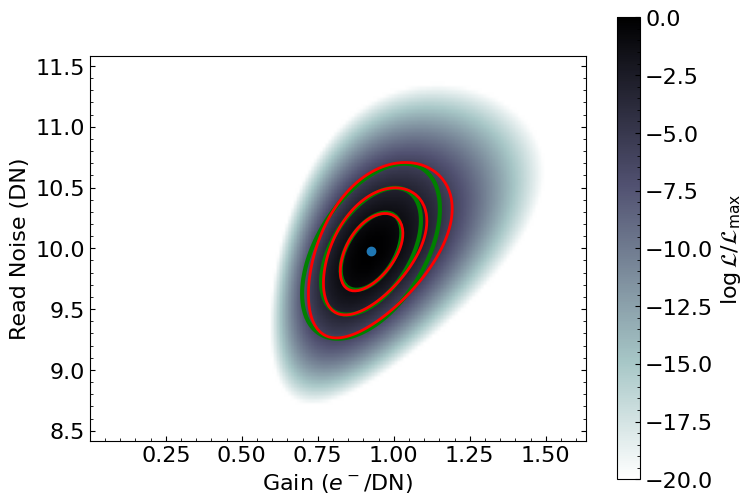

In [3]:
sigs = truesig + np.linspace(-0.5*s, 0.5*s, 101)
gains = truegain + np.linspace(-0.4*s, 0.20001*s, 201)
sigs = sigs[sigs > 0]
gains = gains[gains > 0]

C = fitramp.Covar(readtimes)

y0 = 0
diffs_lin = np.diff(ramps, axis=0)
diffs_quad = np.diff((ramps - y0)**2, axis=0)

likelihoods = fit_gain.gen_likelihood_map(diffs_lin, diffs_quad, C, sigs, gains, [0])[..., 0]

print(diffs_lin.shape)
#likelihoods -= 100*np.log(gains[None, :]/sigs[:, None])

maxL = np.amax(likelihoods)

plt.figure(figsize=(8, 6))

# color plot of the log likelihood: limits
extent = [gains[0], gains[-1], sigs[0], sigs[-1]]

plt.imshow(likelihoods - maxL, origin='lower', aspect=0.4,
           extent=extent, vmin=-20, vmax=0, cmap='bone_r')
plt.colorbar(label="$\log {\\cal L}/{\\cal L}_{\\rm max}$")

# The quadratic form fit, followed by the maximum value that the quadratic
# form takes and the maximum value seen on the dense grid.  Run the 
# quadratric form fit twice to make sure we get very close to the maximum 
# of the likelihood.
for i in range(2):
    # three points each in read noise and gain to fit a quadratic form
    if i == 0:
        sigs_short = np.arange(-1, 2)*0.1*s + truesig
        gains_short = np.arange(-1, 2)*0.03*s + truegain
    else:
        sigs_short = np.arange(-1, 2)*0.1*s + yc
        gains_short = np.arange(-1, 2)*0.03*s + xc
    (xc, yc), cov, coefs = fit_gain.fitquad(diffs_lin, diffs_quad, C, 
                                            sigs_short, gains_short, log=False)

maxval = (coefs[0] + coefs[1]*xc + coefs[2]*yc + coefs[3]*xc*yc
          + coefs[4]*xc**2 + coefs[5]*yc**2)

xx, yy = np.meshgrid(gains, sigs)

f = (coefs[0] + coefs[1]*xx + coefs[2]*yy + coefs[3]*xx*yy
      + coefs[4]*xx**2 + coefs[5]*yy**2) - maxval

# Draw the 1-, 2-, and 3-sigma contours implied by the quadratic form
# fit to the log likelihood.

plt.contour(f, extent=extent, levels=[-11.8/2, -6.2/2, -2.3/2], 
            colors=['g', 'g', 'g'])

plt.xlabel("Gain ($e^-$/DN)")
plt.ylabel("Read Noise (DN)")
plt.contour(likelihoods, extent=extent,
            levels=[maxL - 11.8/2, maxL - 6.2/2, maxL - 2.3/2],
            colors=['r', 'r', 'r'], linewidths=[2, 2, 2])
plt.plot(xc, yc, marker='o', linestyle='')
plt.show()

Compute a two-dimensional log likelihood, with logarithmic spacing in gain and read noise.  

Compute contours to the log likelihood, both explicitly and by fitting a quadratic form.

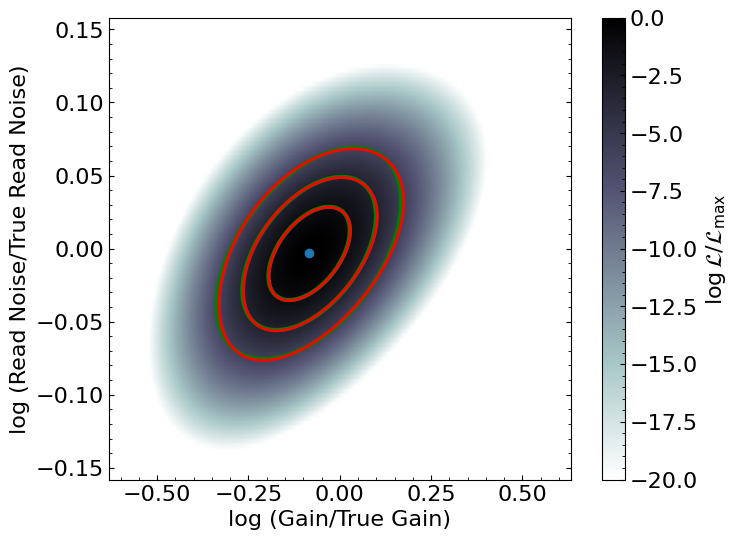

In [4]:
sigs = truesig*np.exp(np.linspace(-0.5*s, 0.5*s, 101)/truesig)
gains = truegain*np.exp(np.linspace(-0.2*s, 0.20001*s, 201))
                    
# The full log likelihood over a dense grid
y0 = 0
diffs_lin = np.diff(ramps, axis=0)
diffs_quad = np.diff((ramps - y0)**2, axis=0)

likelihoods = fit_gain.gen_likelihood_map(diffs_lin, diffs_quad, C, sigs, gains, [0])[..., 0]

# The quadratic form fit, followed by the maximum value that the quadratic
# form takes and the maximum value seen on the dense grid.  The quadratic
# form fit will now be quadratic in log(gain) and log(readnoise).

# The quadratic form fit, followed by the maximum value that the quadratic
# form takes and the maximum value seen on the dense grid.  Run the 
# quadratric form fit twice to make sure we get very close to the maximum 
# of the likelihood.
for i in range(2):
# three points each in read noise and gain to fit a quadratic form
    if i == 0:
        sigs_short = truesig*np.exp(np.arange(-1, 2)*0.01*s)
        gains_short = truegain*np.exp(np.arange(-1, 2)*0.03*s)
    else:
        sigs_short = np.exp(np.arange(-1, 2)*0.01*s + yc)
        gains_short = np.exp(np.arange(-1, 2)*0.03*s + xc)
    (xc, yc), cov, coefs = fit_gain.fitquad(diffs_lin, diffs_quad, C, sigs_short, gains_short)

maxval = (coefs[0] + coefs[1]*xc + coefs[2]*yc + coefs[3]*xc*yc
          + coefs[4]*xc**2 + coefs[5]*yc**2)
maxL = np.amax(likelihoods)

plt.figure(figsize=(8, 6))

# color plot of the log likelihood: the axes in this case are logarithmic.
extent = [np.log(gains[0]/truegain), np.log(gains[-1]/truegain),
                   np.log(sigs[0]/truesig), np.log(sigs[-1]/truesig)]

plt.imshow(likelihoods - maxL, origin='lower', aspect=4,
           extent=extent, vmin=-20, vmax=0, cmap='bone_r')
plt.colorbar(label="$\log {\\cal L}/{\\cal L}_{\\rm max}$")


xx, yy = np.meshgrid(np.log(gains), np.log(sigs))

f = (coefs[0] + coefs[1]*xx + coefs[2]*yy + coefs[3]*xx*yy
      + coefs[4]*xx**2 + coefs[5]*yy**2) - maxval

plt.contour(f, extent=extent, levels=[-11.8/2, -6.2/2, -2.3/2], 
            colors=['g', 'g', 'g'])

plt.xlabel("log (Gain/True Gain)")
plt.ylabel("log (Read Noise/True Read Noise)")
plt.contour(likelihoods, extent=extent,
            levels=[maxL - 11.8/2, maxL - 6.2/2, maxL - 2.3/2],
            colors=['r', 'r', 'r'], linewidths=[2, 2, 2])

plt.plot(xc - np.log(truegain), yc - np.log(truesig), marker='o', linestyle='')
plt.show()

Numerically marginalize the log likelihood from above, show that it is very accurately approximated by a 1D Gaussian with the mean and variance derived from the quadratic form fit.

0.07349719116563674


<Figure size 640x480 with 0 Axes>

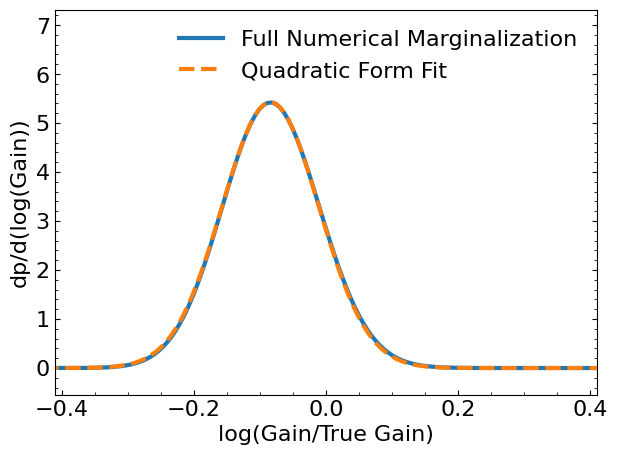

In [5]:
# Explicit numerical marginalization first

pdens = np.sum(np.exp(likelihoods - np.amax(likelihoods)), axis=0)
pdens /= np.sum(pdens)
_x = np.log(gains)
pdens /= _x[1] - _x[0]

plt.clf()
plt.figure(figsize=(7, 5))
plt.plot(_x - np.log(truegain), pdens, label="Full Numerical Marginalization")

# Then the uncertainty from fitting a quadratic form

sig_x = np.sqrt(cov[0, 0])
plt.plot(_x - np.log(truegain), 1/np.sqrt(2*np.pi*sig_x**2)*np.exp(-0.5*(_x - xc)**2/sig_x**2),
         label="Quadratic Form Fit", linestyle='--')
print(sig_x)
plt.xlim(-0.13*s, 0.13*s)
plt.ylim(-np.amax(pdens)/10, np.amax(pdens)*1.35)
plt.xlabel("log(Gain/True Gain)")
plt.ylabel("dp/d(log(Gain))")
plt.legend(frameon=False)
plt.show()

Now show the (lack of) bias by generating many different realizations of the set of ramps at this count rate.  The count rate (from earlier) may be adjusted; the number of ramps to generate can also be adjusted.

-0.0184482586927305 0.9940995492252889


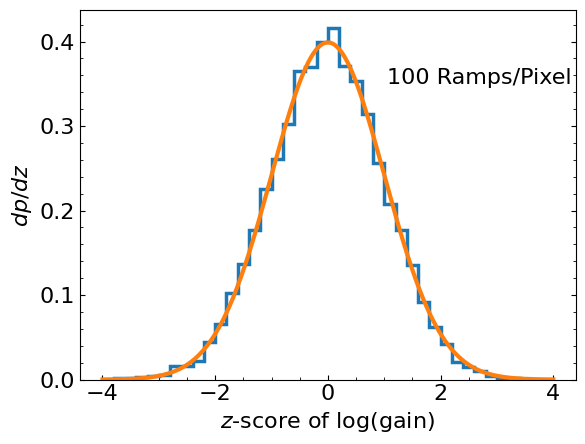

In [6]:
zscores = []

for i in range(10000):
    
    ramps = fitramp.getramps(countrate, truesig*truegain, readtimes, nramps=Nramps)/truegain
    y0 = 0
    diffs_lin = np.diff(ramps, axis=0)
    diffs_quad = np.diff((ramps - y0)**2, axis=0)

    for j in range(2):
    # three points each in read noise and gain to fit a quadratic form
        if j == 0:
            sigs_short = truesig*np.exp(np.arange(-1, 2)*0.01*s)
            gains_short = truegain*np.exp(np.arange(-1, 2)*0.03*s)
        else:
            sigs_short = np.exp(np.arange(-1, 2)*0.01*s + yc)
            gains_short = np.exp(np.arange(-1, 2)*0.03*s + xc)
        (xc, yc), cov, coefs = fit_gain.fitquad(diffs_lin, diffs_quad, C, sigs_short, gains_short)
    
    zscores += [xc/np.sqrt(cov[0, 0])]
        
print(np.mean(zscores), np.std(zscores))
plt.hist(zscores, bins=np.arange(-4, 4.1, 0.2), density=True, histtype='step', linewidth=2.5)
_x = np.linspace(-4, 4, 1000)
plt.plot(_x, 1/np.sqrt(2*np.pi)*np.exp(-_x**2/2))
plt.xlabel('$z$-score of log(gain)')
plt.ylabel('$dp/dz$')
plt.text(1.05, 0.35, "%d Ramps/Pixel" % (Nramps))
plt.show()

Finally, show the difference between fitting ramps with a three-dimensional quadratic form fit to the log likelihood (linearity coefficient being the first parameter), and fitting a two-dimensional quadratic form at the nonlinearity coefficient that yields the highest best-fit gain.

Iteration 1 of 10000
Iteration 1001 of 10000
Iteration 2001 of 10000
Iteration 3001 of 10000
Iteration 4001 of 10000
Iteration 5001 of 10000
Iteration 6001 of 10000
Iteration 7001 of 10000
Iteration 8001 of 10000
Iteration 9001 of 10000
total time: 174.5 seconds
Number of failed fits:  3D optimization: 0; 2D optimization at max gain: 0
Median nonlinearity correction: 9.52e-07; 3.05e-06
Median Error in log(readnoise): -0.00948; -0.0029
Median Error in log(gain): -0.028; -0.000915


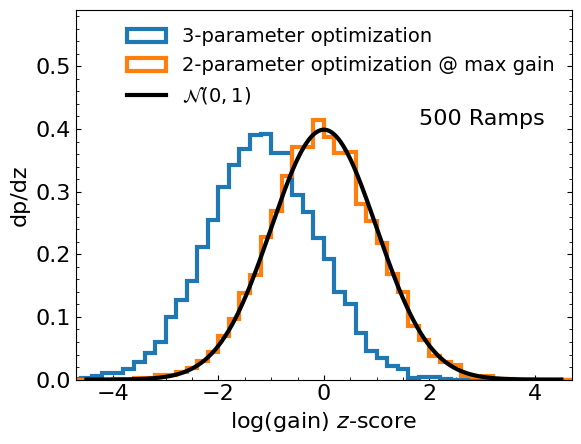

In [7]:
import time

truesig = 10  # in DN
Nramps = 500  # number of ramps
Nres = 50     # number of resultants/ramp
truegain = 1 # electrons/DN
alpha_true = 4e-6 # Nonlinearity coefficient

niterations = 10000 # Reduce this to reduce run time.

# count rate in units of electrons per read
countrate = 200*(np.random.rand(Nramps) + 1)/2
countrate[:Nramps//2] = 0
#countrate[:-2] = 0
countratesidentical = False

readtimes = np.arange(Nres) + 1

# Make some ramps with the desired count rates and the correct read
# and photon noise.  Convert read noise to electrons, make the ramps,
# and then convert back to DN.

gainlist1 = []
gainerrs1 = []
gainlist2 = []
gainerrs2 = []
rnlist1 = []
rnlist2 = []
rnerrs1 = []
rnerrs2 = []
alph1 = [] 
alph2 = [] 

nbad = 0
nbad_3par = 0
t0 = time.time()

for niter in range(niterations):
    if niter%1000 == 0:
        print("Iteration %d of %d" % (niter + 1, niterations))

    ramps = fitramp.getramps(countrate, 0, readtimes, nramps=Nramps)/truegain
    ramps += np.random.randn(*ramps.shape)*truesig

    # This imposes nonlinearity that will be precisely undone by a 
    # quadratic nonlinearity correction.
    ramps = (np.sqrt(1 + 4*alpha_true*ramps) - 1)/(2*alpha_true)

    C = fitramp.Covar(readtimes)
    
    # This value will anchor the nonlinearity correction.
    
    y0 = 0 

    # This parameter helps set the increment of gain and read noise.
    s = np.sqrt(30000/(Nramps*Nres))

    # First do a three-parameter optimization, where the third
    # parameter is the nonlinearity coefficient.  Perform two 
    # iterations to converge.  The second iteration will 
    # recenter the lists of gain, read noise, and nonlinearity
    # coefficient at which to fit a quadratic form.
    # Guesses on gain and nonlinearity are good but not perfect.
    
    sigs = 10*np.exp(np.arange(-1, 2)*0.01*s)
    gains = 1.5*np.exp(np.arange(-1, 2)*0.03*s)
    alphas = [0, 2e-6, 4e-6]
    
    diffs_lin = np.diff(ramps, axis=0)
    diffs_quad = np.diff((ramps - y0)**2, axis=0)
    (xc, yc, zc), cov, coefs = fit_gain.fitquad(diffs_lin, diffs_quad, C, 
                                                sigs, gains, alphas=alphas)
    
    sigs = np.exp(np.arange(-1, 2)*0.01*s + yc)
    gains = np.exp(np.arange(-1, 2)*0.03*s + xc)
    alphas = np.arange(-1, 2)*3e-7*s + zc

    (xc, yc, zc), cov, coefs = fit_gain.fitquad(diffs_lin, diffs_quad, C, 
                                                sigs, gains, alphas=alphas)
    
    if cov[0, 0] <= 0 or np.abs(xc - np.log(truegain))/np.sqrt(cov[0, 0]) < 8:
        gainlist1 += [xc - np.log(truegain)]
        gainerrs1 += [np.sqrt(cov[0, 0])]
        rnlist1 += [yc - np.log(truesig)]
        rnerrs1 += [np.sqrt(cov[1, 1])]
        alph1 += [zc]
    else:
        nbad_3par += 1
        
    # Now do a two-parameter optimization over gain and read noise
    # at the nonlinearity coefficient that yields the highest 
    # best-fit gain.  Note that the guesses on nonlinearity and 
    # gain are ok, but not great.

    darkramps = ramps[:, :Nramps//2]
    illumramps = ramps[:, Nramps//2:]

    # The actual gain will be np.exp(xc).
    # The actual read noise will be np.exp(yc).  
    
    xc, yc, zc, cov = fit_gain.fit_gain_linearity(darkramps, illumramps, fit_nonlin=True,
                                       alpha_offset=2e-6, dalpha=2e-6, dalpha2=5e-7,
                                       gainguess=1.5, maxiter_nonlin=10, snrscalefac=1)

    if cov[0, 0] <= 0 or np.abs(xc - np.log(truegain))/np.sqrt(cov[0, 0]) < 8:
        gainlist2 += [xc - np.log(truegain)]
        gainerrs2 += [np.sqrt(cov[0, 0])]
        alph2 += [zc]
        rnlist2 += [yc - np.log(truesig)]
        rnerrs2 += [np.sqrt(cov[1, 1])]
    else:
        nbad += 1

print('total time: %.1f seconds' % (time.time() - t0))
print("Number of failed fits:  3D optimization: %d; 2D optimization at max gain: %d" % (nbad_3par, nbad))
print("Median nonlinearity correction: %.3g; %.3g" % (np.median(alph1), np.median(alph2)))
print("Median Error in log(readnoise): %.3g; %.3g" % (np.median(rnlist1), np.median(rnlist2)))
print("Median Error in log(gain): %.3g; %.3g" % (np.median(gainlist1), np.median(gainlist2)))
zscores1 = (np.array(gainlist1))/np.array(gainerrs1)
zscores2 = (np.array(gainlist2))/np.array(gainerrs2)
plt.hist(zscores1, bins=np.arange(-5, 5.2, 0.2), density=True, histtype='step', linewidth=3, label="3-parameter optimization")
plt.hist(zscores2, bins=np.arange(-5, 5.2, 0.2), density=True, histtype='step', linewidth=3, label="2-parameter optimization @ max gain")

xval = np.linspace(-4.5, 4.5, 1000)
plt.plot(xval, 1/np.sqrt(2*np.pi)*np.exp(-xval**2/2), label="${\cal N}(0, 1)$", color='k')
plt.legend(frameon=False, fontsize=14)
plt.text(3, 0.4, "%d Ramps" % (Nramps), horizontalalignment='center', verticalalignment='bottom')

plt.xlabel("log(gain) $z$-score")
plt.ylabel("dp/dz")
plt.ylim(0, 0.59)
plt.xlim(-4.7, 4.7)
plt.show()